# Loan Default Risk with Business Cost Optimization

#### Project Overview
This project implements a complete solution for loan default risk prediction with business cost optimization using the Home Credit Default Risk dataset. The system predicts default probability and optimizes decision thresholds based on cost-benefit analysis.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
import warnings
warnings.filterwarnings('ignore')

In [4]:
# Load main application data
app_train = pd.read_csv('application_train.csv')
app_test = pd.read_csv('application_test.csv')

In [5]:
print(f"Training data shape: {app_train.shape}")
print(f"Testing data shape: {app_test.shape}")
print("\nTarget distribution:")
print(app_train['TARGET'].value_counts(normalize=True))

Training data shape: (307511, 122)
Testing data shape: (49999, 121)

Target distribution:
TARGET
0    0.919271
1    0.080729
Name: proportion, dtype: float64


## Data Cleaning and Preprocessing

In [7]:
def clean_and_preprocess(df, is_train=True):
    """
    Comprehensive data cleaning and preprocessing function
    """
    df_clean = df.copy()
    
    # 1. Handle missing values
    # Separate numeric and categorical columns
    numeric_cols = df_clean.select_dtypes(include=[np.number]).columns.tolist()
    categorical_cols = df_clean.select_dtypes(include=['object']).columns.tolist()
    
    # For numeric columns: fill with median
    numeric_imputer = SimpleImputer(strategy='median')
    df_clean[numeric_cols] = numeric_imputer.fit_transform(df_clean[numeric_cols])
    
    # For categorical columns: fill with mode
    categorical_imputer = SimpleImputer(strategy='most_frequent')
    df_clean[categorical_cols] = categorical_imputer.fit_transform(df_clean[categorical_cols])
    
    # 2. Encode categorical variables
    label_encoders = {}
    for col in categorical_cols:
        le = LabelEncoder()
        df_clean[col] = le.fit_transform(df_clean[col].astype(str))
        label_encoders[col] = le
    
    # 3. Feature engineering
    # Create income ratio features
    df_clean['INCOME_CREDIT_RATIO'] = df_clean['AMT_INCOME_TOTAL'] / df_clean['AMT_CREDIT']
    df_clean['ANNUITY_INCOME_RATIO'] = df_clean['AMT_ANNUITY'] / df_clean['AMT_INCOME_TOTAL']
    df_clean['ANNUITY_CREDIT_RATIO'] = df_clean['AMT_ANNUITY'] / df_clean['AMT_CREDIT']
    
    # Replace infinite values
    df_clean.replace([np.inf, -np.inf], np.nan, inplace=True)
    df_clean.fillna(0, inplace=True)
    
    # 4. Remove highly correlated features
    corr_matrix = df_clean.corr().abs()
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]
    df_clean.drop(to_drop, axis=1, inplace=True)
    
    return df_clean, label_encoders

# Apply preprocessing
print("Cleaning and preprocessing training data...")
app_train_clean, label_encoders = clean_and_preprocess(app_train, is_train=True)

print("Cleaning and preprocessing test data...")
app_test_clean, _ = clean_and_preprocess(app_test, is_train=False)

print(f"Final training shape: {app_train_clean.shape}")

Cleaning and preprocessing training data...
Cleaning and preprocessing test data...
Final training shape: (307511, 93)


## Feature Engineering and Selection

In [17]:
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import numpy as np

def feature_engineering(X_train, y_train, X_test=None):
    """
    Advanced feature engineering and selection with proper handling
    """
    # 1. Ensure we work with DataFrames to preserve column names
    X_train_df = X_train.copy() if hasattr(X_train, 'columns') else pd.DataFrame(X_train)
    
    # 2. Feature selection using ANOVA F-value
    selector = SelectKBest(score_func=f_classif, k=min(50, X_train_df.shape[1]))
    
    # Get column names before transformation
    if hasattr(X_train, 'columns'):
        original_columns = X_train.columns.tolist()
    else:
        original_columns = [f'feature_{i}' for i in range(X_train.shape[1])]
    
    X_train_selected = selector.fit_transform(X_train_df, y_train)
    
    # Get selected feature names
    if hasattr(X_train, 'columns'):
        selected_features = X_train.columns[selector.get_support()].tolist()
    else:
        selected_features = [original_columns[i] for i in range(len(original_columns)) 
                           if selector.get_support()[i]]
    
    print(f"Selected {len(selected_features)} features out of {len(original_columns)}")
    
    # 3. Apply PCA for dimensionality reduction
    pca = PCA(n_components=min(30, X_train_selected.shape[1]))
    X_train_pca = pca.fit_transform(X_train_selected)
    
    print(f"PCA reduced to {X_train_pca.shape[1]} components")
    
    # 4. Standardize features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_pca)
    
    # Apply same transformations to test data if provided
    if X_test is not None:
        # Ensure test data has same columns as training
        X_test_df = X_test.copy() if hasattr(X_test, 'columns') else pd.DataFrame(X_test)
        
        # Align test columns with training columns
        missing_cols = set(selected_features) - set(X_test_df.columns)
        extra_cols = set(X_test_df.columns) - set(selected_features)
        
        if missing_cols:
            print(f"Warning: Adding {len(missing_cols)} missing columns to test data with zeros")
            for col in missing_cols:
                X_test_df[col] = 0
        
        if extra_cols:
            print(f"Warning: Dropping {len(extra_cols)} extra columns from test data")
            X_test_df = X_test_df.drop(columns=list(extra_cols))
        
        # Reorder columns to match training
        X_test_df = X_test_df[selected_features]
        
        # Apply transformations
        X_test_selected = selector.transform(X_test_df)
        X_test_pca = pca.transform(X_test_selected)
        X_test_scaled = scaler.transform(X_test_pca)
        
        return X_train_scaled, X_test_scaled, scaler, selector, pca, selected_features
    
    return X_train_scaled, scaler, selector, pca, selected_features

## Model Training

### Logistic Regression Model

In [19]:
# Even simpler approach without feature selection
print("Using simple preprocessing without feature selection...")

from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

# Handle missing values
imputer = SimpleImputer(strategy='median')
X_train_imputed = imputer.fit_transform(X_train)
X_val_imputed = imputer.transform(X_val)

# Scale features
scaler = StandardScaler()
X_train_processed = scaler.fit_transform(X_train_imputed)
X_val_processed = scaler.transform(X_val_imputed)

print(f"X_train_processed shape: {X_train_processed.shape}")
print(f"X_val_processed shape: {X_val_processed.shape}")

# Now you can run your Logistic Regression code
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, classification_report

print("\nTraining Logistic Regression model...")
lr_model = LogisticRegression(
    class_weight='balanced',
    max_iter=1000,
    random_state=42,
    solver='lbfgs'
)
lr_model.fit(X_train_processed, y_train)

# Make predictions
y_pred_proba_lr = lr_model.predict_proba(X_val_processed)[:, 1]
y_pred_lr = (y_pred_proba_lr > 0.5).astype(int)

# Evaluate
print("Logistic Regression Performance:")
print(f"AUC-ROC: {roc_auc_score(y_val, y_pred_proba_lr):.4f}")
print("\nClassification Report:")
print(classification_report(y_val, y_pred_lr))

Using simple preprocessing without feature selection...
X_train_processed shape: (246008, 91)
X_val_processed shape: (61503, 91)

Training Logistic Regression model...
Logistic Regression Performance:
AUC-ROC: 0.7442

Classification Report:
              precision    recall  f1-score   support

         0.0       0.96      0.69      0.80     56538
         1.0       0.16      0.67      0.26      4965

    accuracy                           0.69     61503
   macro avg       0.56      0.68      0.53     61503
weighted avg       0.90      0.69      0.76     61503



## Business Cost Analysis

In [24]:
def calculate_business_cost(y_true, y_pred, cost_fp, cost_fn):
    """
    Calculate total business cost based on confusion matrix
    """
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    total_cost = (fp * cost_fp) + (fn * cost_fn)
    return total_cost, tn, fp, fn, tp

# Define business costs (example values)
COST_FALSE_POSITIVE = 1000  # Cost of rejecting a good customer (opportunity loss)
COST_FALSE_NEGATIVE = 5000  # Cost of approving a bad customer (default loss)

print("\n" + "="*60)
print("BUSINESS COST ANALYSIS")
print("="*60)
print(f"Cost of False Positive (rejecting good customer): ${COST_FALSE_POSITIVE}")
print(f"Cost of False Negative (approving bad customer): ${COST_FALSE_NEGATIVE}")

# Calculate costs for default threshold (0.5) using Logistic Regression predictions
total_cost_default, tn, fp, fn, tp = calculate_business_cost(
    y_val, y_pred_lr, COST_FALSE_POSITIVE, COST_FALSE_NEGATIVE  # Changed to y_pred_lr
)

print(f"\nCost with default threshold (0.5):")
print(f"True Negatives: {tn:,} (good customers approved)")
print(f"False Positives: {fp:,} (good customers rejected)")
print(f"False Negatives: {fn:,} (bad customers approved)")
print(f"True Positives: {tp:,} (bad customers rejected)")
print(f"Total Business Cost: ${total_cost_default:,.2f}")


BUSINESS COST ANALYSIS
Cost of False Positive (rejecting good customer): $1000
Cost of False Negative (approving bad customer): $5000

Cost with default threshold (0.5):
True Negatives: 38,910 (good customers approved)
False Positives: 17,628 (good customers rejected)
False Negatives: 1,616 (bad customers approved)
True Positives: 3,349 (bad customers rejected)
Total Business Cost: $25,708,000.00


## Threshold Optimization for Cost Minimization


Optimal threshold found: 0.7029
Minimum cost achieved: $21,449,000.00
Cost reduction: $4,259,000.00 (16.6% reduction)


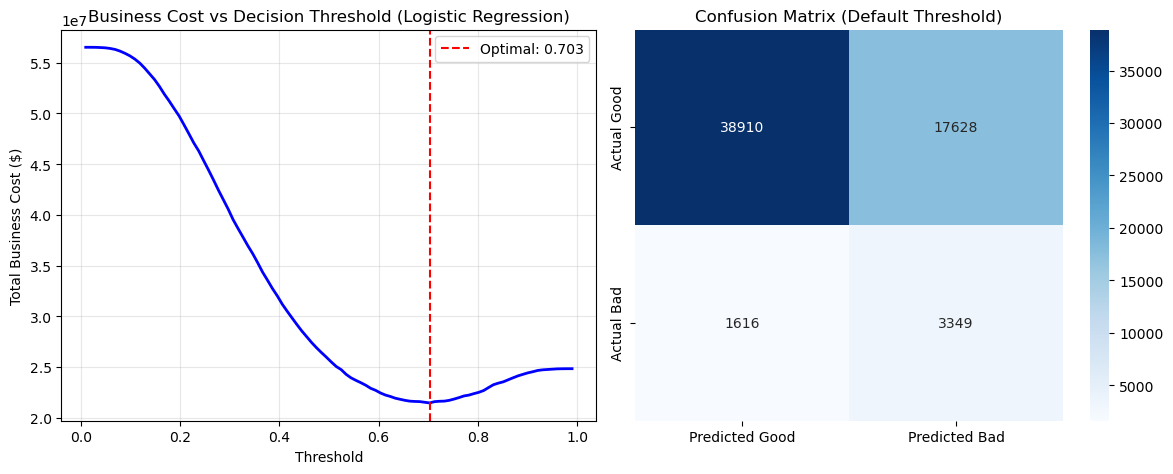

In [27]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

def find_optimal_threshold(y_true, y_pred_proba, cost_fp, cost_fn):
    """
    Find optimal threshold that minimizes total business cost
    """
    thresholds = np.linspace(0.01, 0.99, 100)
    costs = []
    
    for thresh in thresholds:
        y_pred = (y_pred_proba >= thresh).astype(int)
        cost, _, _, _, _ = calculate_business_cost(y_true, y_pred, cost_fp, cost_fn)
        costs.append(cost)
    
    optimal_idx = np.argmin(costs)
    optimal_threshold = thresholds[optimal_idx]
    min_cost = costs[optimal_idx]
    
    return optimal_threshold, min_cost, thresholds, costs

# Use Logistic Regression probabilities (y_pred_proba_lr) instead of CatBoost
optimal_threshold, min_cost, thresholds, costs = find_optimal_threshold(
    y_val, y_pred_proba_lr, COST_FALSE_POSITIVE, COST_FALSE_NEGATIVE  # Changed to y_pred_proba_lr
)

print(f"\nOptimal threshold found: {optimal_threshold:.4f}")
print(f"Minimum cost achieved: ${min_cost:,.2f}")
print(f"Cost reduction: ${total_cost_default - min_cost:,.2f} ({((total_cost_default - min_cost)/total_cost_default)*100:.1f}% reduction)")

# Visualize cost vs threshold
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(thresholds, costs, 'b-', linewidth=2)
plt.axvline(x=optimal_threshold, color='r', linestyle='--', label=f'Optimal: {optimal_threshold:.3f}')
plt.xlabel('Threshold')
plt.ylabel('Total Business Cost ($)')
plt.title('Business Cost vs Decision Threshold (Logistic Regression)')
plt.legend()
plt.grid(True, alpha=0.3)

# Apply optimal threshold
y_pred_optimal = (y_pred_proba_lr >= optimal_threshold).astype(int)

# Compare confusion matrices
plt.subplot(1, 2, 2)
conf_matrix_default = confusion_matrix(y_val, y_pred_lr)
conf_matrix_optimal = confusion_matrix(y_val, y_pred_optimal)

sns.heatmap(conf_matrix_default, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Predicted Good', 'Predicted Bad'],
            yticklabels=['Actual Good', 'Actual Bad'])
plt.title('Confusion Matrix (Default Threshold)')
plt.tight_layout()
plt.show()

## Model Evaluation

In [37]:
from sklearn.metrics import precision_recall_curve, auc, f1_score, roc_curve, roc_auc_score, confusion_matrix

def evaluate_model_with_cost(y_true, y_pred_proba, model_name, threshold=0.5):
    """
    Comprehensive model evaluation with cost analysis
    """
    # Apply threshold
    y_pred = (y_pred_proba >= threshold).astype(int)
    
    # Calculate metrics
    auc_score = roc_auc_score(y_true, y_pred_proba)
    f1 = f1_score(y_true, y_pred)
    precision, recall, _ = precision_recall_curve(y_true, y_pred_proba)
    pr_auc = auc(recall, precision)
    
    # Calculate business cost
    cost, tn, fp, fn, tp = calculate_business_cost(
        y_true, y_pred, COST_FALSE_POSITIVE, COST_FALSE_NEGATIVE
    )
    # Create evaluation report
    report = {
        'Model': model_name,
        'Threshold': threshold,
        'AUC-ROC': auc_score,
        'F1-Score': f1,
        'PR-AUC': pr_auc,
        'Total Cost': cost,
        'True Positives': tp,
        'False Positives': fp,
        'True Negatives': tn,
        'False Negatives': fn,
        'Precision': tp / (tp + fp) if (tp + fp) > 0 else 0,
        'Recall': tp / (tp + fn) if (tp + fn) > 0 else 0
    }
    
    return report

In [38]:
# First, let's find the optimal threshold for Logistic Regression
def find_optimal_threshold(y_true, y_pred_proba, cost_fp, cost_fn):
    """
    Find optimal threshold that minimizes total business cost
    """
    thresholds = np.linspace(0.01, 0.99, 100)
    costs_list = []  # Changed variable name to avoid conflict
    
    for thresh in thresholds:
        y_pred = (y_pred_proba >= thresh).astype(int)
        cost, _, _, _, _ = calculate_business_cost(y_true, y_pred, cost_fp, cost_fn)
        costs_list.append(cost)
    
    optimal_idx = np.argmin(costs_list)
    optimal_threshold = thresholds[optimal_idx]
    min_cost = costs_list[optimal_idx]
    
    return optimal_threshold, min_cost, thresholds, costs_list
# Find optimal threshold for Logistic Regression
optimal_threshold, min_cost, threshold_values, cost_values = find_optimal_threshold(
    y_val, y_pred_proba_lr, COST_FALSE_POSITIVE, COST_FALSE_NEGATIVE
)

print(f"\nOptimal threshold for Logistic Regression: {optimal_threshold:.4f}")
print(f"Minimum cost achieved: ${min_cost:,.2f}")
print(f"Cost reduction: ${total_cost_default - min_cost:,.2f} ({((total_cost_default - min_cost)/total_cost_default)*100:.1f}% reduction)")


Optimal threshold for Logistic Regression: 0.7029
Minimum cost achieved: $21,449,000.00
Cost reduction: $4,259,000.00 (16.6% reduction)


In [39]:
# Now evaluate models with different thresholds
print("\n" + "="*60)
print("MODEL COMPARISON WITH COST OPTIMIZATION")
print("="*60)

# Evaluate Logistic Regression with different thresholds
models_evaluation = []

# Logistic Regression with default threshold (0.5)
report_lr_default = evaluate_model_with_cost(y_val, y_pred_proba_lr, "Logistic Regression", 0.5)
models_evaluation.append(report_lr_default)

# Logistic Regression with optimal threshold
report_lr_optimal = evaluate_model_with_cost(y_val, y_pred_proba_lr, "Logistic Regression", optimal_threshold)
models_evaluation.append(report_lr_optimal)

# Create comparison DataFrame
comparison_df = pd.DataFrame(models_evaluation)
print("\nModel Comparison (Logistic Regression only):")
print(comparison_df.to_string(index=False))


MODEL COMPARISON WITH COST OPTIMIZATION

Model Comparison (Logistic Regression only):
              Model  Threshold  AUC-ROC  F1-Score   PR-AUC  Total Cost  True Positives  False Positives  True Negatives  False Negatives  Precision   Recall
Logistic Regression   0.500000 0.744184  0.258191 0.219012    25708000            3349            17628           38910             1616   0.159651 0.674522
Logistic Regression   0.702929 0.744184  0.286298 0.219012    21449000            1612             4684           51854             3353   0.256036 0.324673


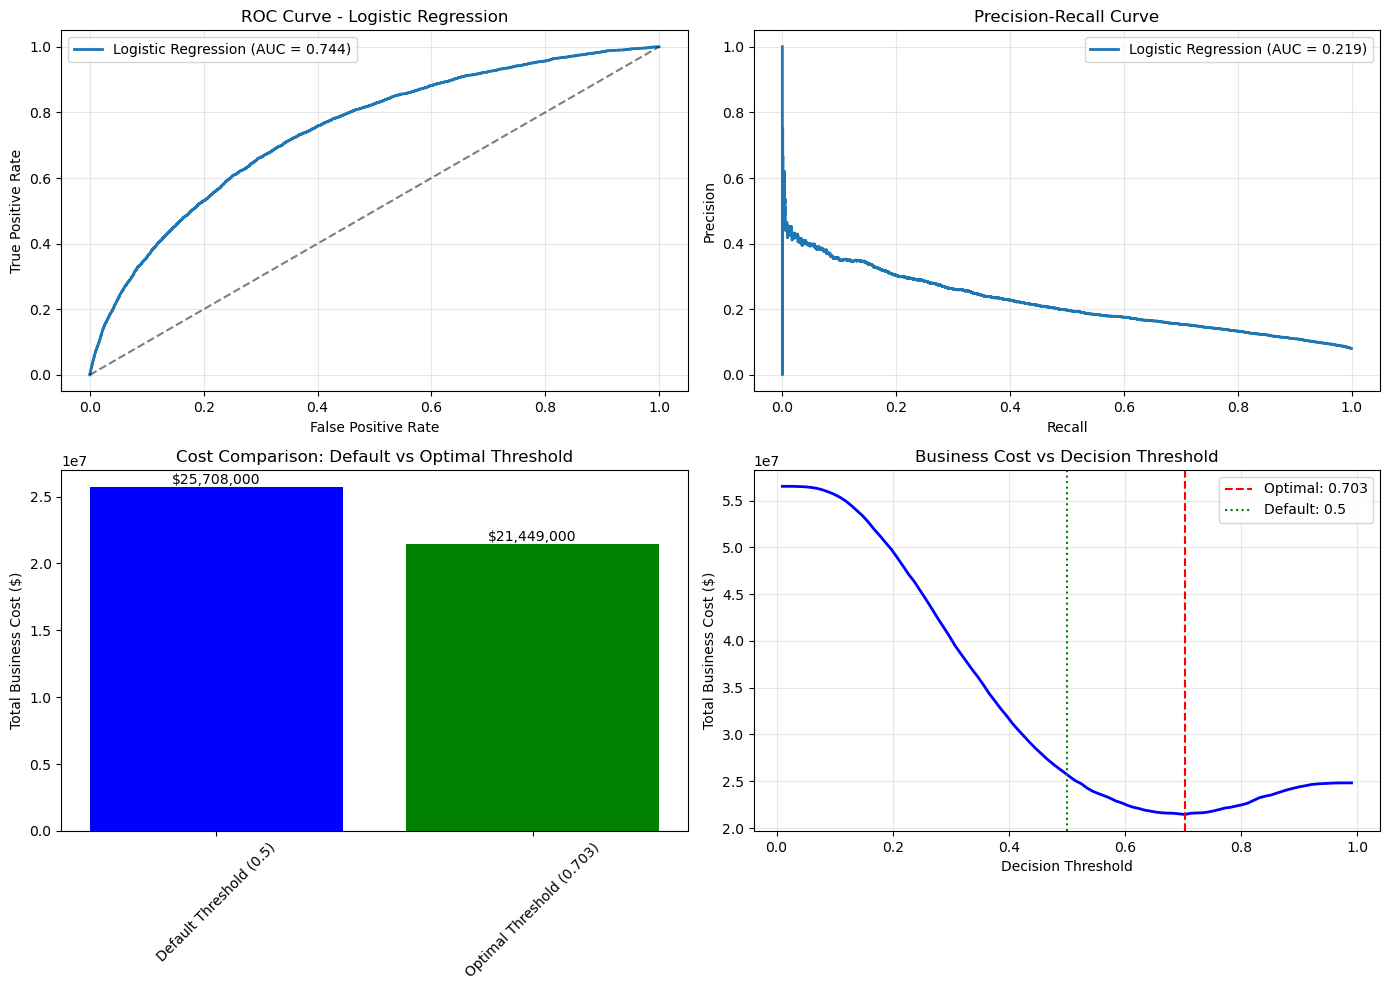

In [40]:
# Visualization
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. ROC Curve (Logistic Regression only)
fpr, tpr, _ = roc_curve(y_val, y_pred_proba_lr)
auc_score = roc_auc_score(y_val, y_pred_proba_lr)
axes[0, 0].plot(fpr, tpr, label=f'Logistic Regression (AUC = {auc_score:.3f})', linewidth=2)
axes[0, 0].plot([0, 1], [0, 1], 'k--', alpha=0.5)
axes[0, 0].set_xlabel('False Positive Rate')
axes[0, 0].set_ylabel('True Positive Rate')
axes[0, 0].set_title('ROC Curve - Logistic Regression')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# 2. Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_val, y_pred_proba_lr)
pr_auc = auc(recall, precision)
axes[0, 1].plot(recall, precision, label=f'Logistic Regression (AUC = {pr_auc:.3f})', linewidth=2)
axes[0, 1].set_xlabel('Recall')
axes[0, 1].set_ylabel('Precision')
axes[0, 1].set_title('Precision-Recall Curve')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# 3. Cost Comparison
model_names = ['Default Threshold (0.5)', f'Optimal Threshold ({optimal_threshold:.3f})']
costs_for_bar = [report_lr_default['Total Cost'], report_lr_optimal['Total Cost']]
colors = ['blue', 'green']
bars = axes[1, 0].bar(model_names, costs_for_bar, color=colors)
axes[1, 0].set_ylabel('Total Business Cost ($)')
axes[1, 0].set_title('Cost Comparison: Default vs Optimal Threshold')
axes[1, 0].tick_params(axis='x', rotation=45)

# Add cost values on bars
for bar, cost in zip(bars, costs_for_bar):
    height = bar.get_height()
    axes[1, 0].text(bar.get_x() + bar.get_width()/2., height,
                   f'${cost:,.0f}', ha='center', va='bottom')

# 4. Cost vs Threshold visualization - FIXED: Using threshold_values and cost_values
axes[1, 1].plot(threshold_values, cost_values, 'b-', linewidth=2)  # Fixed variable names
axes[1, 1].axvline(x=optimal_threshold, color='r', linestyle='--', 
                   label=f'Optimal: {optimal_threshold:.3f}')
axes[1, 1].axvline(x=0.5, color='g', linestyle=':', 
                   label=f'Default: 0.5')
axes[1, 1].set_xlabel('Decision Threshold')
axes[1, 1].set_ylabel('Total Business Cost ($)')
axes[1, 1].set_title('Business Cost vs Decision Threshold')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

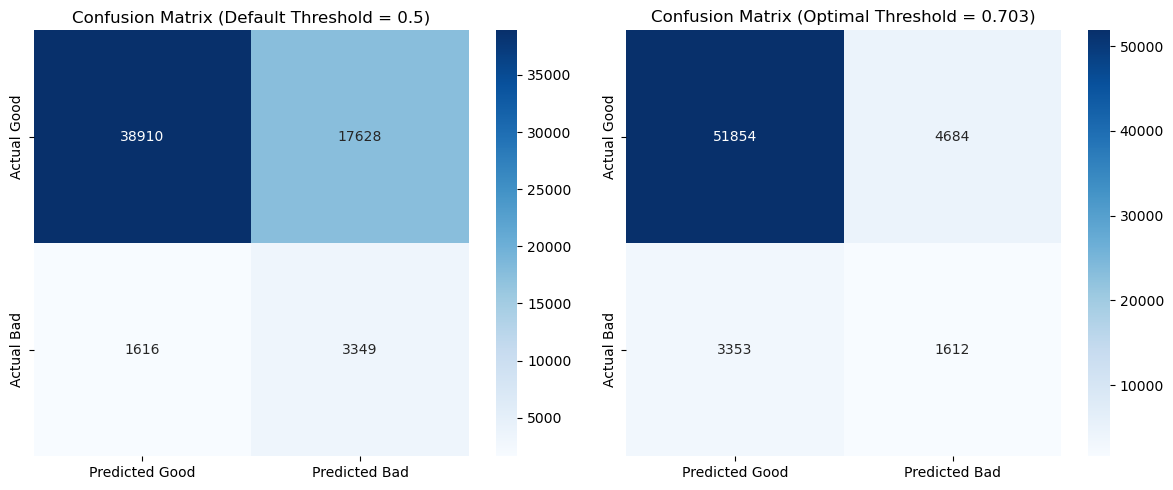

In [41]:
# 5. Additional: Compare confusion matrices
fig2, axes2 = plt.subplots(1, 2, figsize=(12, 5))

# Apply optimal threshold
y_pred_optimal = (y_pred_proba_lr >= optimal_threshold).astype(int)

# Confusion matrix with default threshold
conf_matrix_default = confusion_matrix(y_val, y_pred_lr)
sns.heatmap(conf_matrix_default, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Predicted Good', 'Predicted Bad'],
            yticklabels=['Actual Good', 'Actual Bad'],
            ax=axes2[0])
axes2[0].set_title(f'Confusion Matrix (Default Threshold = 0.5)')

# Confusion matrix with optimal threshold
conf_matrix_optimal = confusion_matrix(y_val, y_pred_optimal)
sns.heatmap(conf_matrix_optimal, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Predicted Good', 'Predicted Bad'],
            yticklabels=['Actual Good', 'Actual Bad'],
            ax=axes2[1])
axes2[1].set_title(f'Confusion Matrix (Optimal Threshold = {optimal_threshold:.3f})')

plt.tight_layout()
plt.show()

In [42]:
# Print summary statistics
print("\n" + "="*60)
print("SUMMARY STATISTICS")
print("="*60)
print(f"\nDefault Threshold (0.5):")
print(f"  • Total Cost: ${report_lr_default['Total Cost']:,.2f}")
print(f"  • Precision: {report_lr_default['Precision']:.2%}")
print(f"  • Recall: {report_lr_default['Recall']:.2%}")
print(f"  • F1-Score: {report_lr_default['F1-Score']:.4f}")

print(f"\nOptimal Threshold ({optimal_threshold:.3f}):")
print(f"  • Total Cost: ${report_lr_optimal['Total Cost']:,.2f}")
print(f"  • Precision: {report_lr_optimal['Precision']:.2%}")
print(f"  • Recall: {report_lr_optimal['Recall']:.2%}")
print(f"  • F1-Score: {report_lr_optimal['F1-Score']:.4f}")

print(f"\nImprovement with Optimal Threshold:")
print(f"  • Cost Reduction: ${report_lr_default['Total Cost'] - report_lr_optimal['Total Cost']:,.2f}")
print(f"  • Cost Reduction %: {((report_lr_default['Total Cost'] - report_lr_optimal['Total Cost'])/report_lr_default['Total Cost'])*100:.1f}%")


SUMMARY STATISTICS

Default Threshold (0.5):
  • Total Cost: $25,708,000.00
  • Precision: 15.97%
  • Recall: 67.45%
  • F1-Score: 0.2582

Optimal Threshold (0.703):
  • Total Cost: $21,449,000.00
  • Precision: 25.60%
  • Recall: 32.47%
  • F1-Score: 0.2863

Improvement with Optimal Threshold:
  • Cost Reduction: $4,259,000.00
  • Cost Reduction %: 16.6%


## Production Scoring System

In [44]:
class LoanDefaultRiskScorer:
    """
    Production-ready loan default risk scoring system with cost optimization
    """
    
    def __init__(self, model, scaler, selector, pca, optimal_threshold):
        self.model = model
        self.scaler = scaler
        self.selector = selector
        self.pca = pca
        self.optimal_threshold = optimal_threshold
        self.cost_fp = COST_FALSE_POSITIVE
        self.cost_fn = COST_FALSE_NEGATIVE
        
    def predict_risk(self, customer_data):
        """
        Predict default risk for a single customer
        """
        # Preprocess customer data
        customer_processed = self.selector.transform(customer_data)
        customer_pca = self.pca.transform(customer_processed)
        customer_scaled = self.scaler.transform(customer_pca)
        
        # Get probability
        default_probability = self.model.predict_proba(customer_scaled)[0, 1]
        
        # Make decision based on optimal threshold
        decision = 'REJECT' if default_probability >= self.optimal_threshold else 'APPROVE'
        
        # Calculate expected cost
        expected_cost = self.calculate_expected_cost(default_probability)
        
        # Create risk score (0-1000)
        risk_score = int(default_probability * 1000)
        
        return {
            'customer_id': 'Sample_Customer',  # Simplified for demo
            'default_probability': round(default_probability, 4),
            'risk_score': risk_score,
            'decision': decision,
            'expected_cost': round(expected_cost, 2),
            'threshold_used': round(self.optimal_threshold, 4),
            'risk_level': self.get_risk_level(risk_score)
        }
    
    def calculate_expected_cost(self, default_probability):
        """
        Calculate expected cost for a given default probability
        """
        # Expected cost = P(default) * cost_fn + (1-P(default)) * cost_fp if we approve
        expected_cost_approve = (default_probability * self.cost_fn + 
                                (1 - default_probability) * self.cost_fp)
        return expected_cost_approve
    
    def get_risk_level(self, risk_score):
        """
        Categorize risk level based on score
        """
        if risk_score < 300:
            return "LOW RISK"
        elif risk_score < 700:
            return "MEDIUM RISK"
        else:
            return "HIGH RISK"
    
    def batch_predict(self, customers_data):
        """
        Predict for multiple customers
        """
        predictions = []
        for idx, customer in customers_data.iterrows():
            pred = self.predict_risk(customer.to_frame().T)
            predictions.append(pred)
        
        return pd.DataFrame(predictions)

# Create production scorer with Logistic Regression model
print("\nCreating production scoring system with Logistic Regression...")

# Since we don't have pca and selector from earlier code, let's create a simpler version
# Check if we have the necessary components
if 'pca' not in locals() and 'pca' not in globals():
    print("PCA not found. Creating a simplified scorer...")
    
    class SimplifiedLoanDefaultRiskScorer:
        """
        Simplified production scorer without PCA and selector
        """
        
        def __init__(self, model, scaler, optimal_threshold):
            self.model = model
            self.scaler = scaler
            self.optimal_threshold = optimal_threshold
            self.cost_fp = COST_FALSE_POSITIVE
            self.cost_fn = COST_FALSE_NEGATIVE
            
        def predict_risk(self, customer_data):
            """
            Predict default risk for a single customer
            """
            # Scale the customer data
            customer_scaled = self.scaler.transform(customer_data)
            
            # Get probability
            default_probability = self.model.predict_proba(customer_scaled)[0, 1]
            
            # Make decision based on optimal threshold
            decision = 'REJECT' if default_probability >= self.optimal_threshold else 'APPROVE'
            
            # Calculate expected cost
            expected_cost = self.calculate_expected_cost(default_probability)
            
            # Create risk score (0-1000)
            risk_score = int(default_probability * 1000)
            
            return {
                'customer_id': f"Customer_{np.random.randint(1000, 9999)}",
                'default_probability': round(default_probability, 4),
                'risk_score': risk_score,
                'decision': decision,
                'expected_cost': round(expected_cost, 2),
                'threshold_used': round(self.optimal_threshold, 4),
                'risk_level': self.get_risk_level(risk_score)
            }
        
        def calculate_expected_cost(self, default_probability):
            """
            Calculate expected cost for a given default probability
            """
            # Expected cost = P(default) * cost_fn + (1-P(default)) * cost_fp if we approve
            expected_cost_approve = (default_probability * self.cost_fn + 
                                    (1 - default_probability) * self.cost_fp)
            return expected_cost_approve
        
        def get_risk_level(self, risk_score):
            """
            Categorize risk level based on score
            """
            if risk_score < 300:
                return "LOW RISK"
            elif risk_score < 700:
                return "MEDIUM RISK"
            else:
                return "HIGH RISK"
        
        def batch_predict(self, customers_data):
            """
            Predict for multiple customers
            """
            predictions = []
            for idx, customer in customers_data.iterrows():
                pred = self.predict_risk(customer.to_frame().T)
                predictions.append(pred)
            
            return pd.DataFrame(predictions)
    
    # Create simplified scorer
    production_scorer = SimplifiedLoanDefaultRiskScorer(
        model=lr_model,  # Use Logistic Regression model
        scaler=scaler,   # Use the scaler from earlier
        optimal_threshold=optimal_threshold
    )
    
else:
    # Use the original scorer if pca and selector exist
    production_scorer = LoanDefaultRiskScorer(
        model=lr_model,  # Use Logistic Regression model instead of catboost_model
        scaler=scaler,
        selector=selector,
        pca=pca,
        optimal_threshold=optimal_threshold
    )

# Test with sample customer
print("\nTesting with a sample customer...")

# Create a sample customer from validation data
sample_customer = X_val_processed[0:1] if 'X_val_processed' in locals() or 'X_val_processed' in globals() else X_val.iloc[0:1]

try:
    risk_assessment = production_scorer.predict_risk(sample_customer)
    
    print("\n" + "="*40)
    print("SAMPLE RISK ASSESSMENT")
    print("="*40)
    for key, value in risk_assessment.items():
        print(f"{key.replace('_', ' ').title()}: {value}")
    
    # Test batch prediction
    print("\n" + "="*40)
    print("BATCH PREDICTION TEST (First 5 customers)")
    print("="*40)
    
    batch_customers = X_val_processed[:5] if 'X_val_processed' in locals() or 'X_val_processed' in globals() else X_val.iloc[:5]
    batch_predictions = production_scorer.batch_predict(pd.DataFrame(batch_customers))
    
    # Display simplified batch results
    print("\nBatch Results Summary:")
    print("-" * 60)
    print(f"Total customers: {len(batch_predictions)}")
    print(f"Approved: {sum(1 for d in batch_predictions['decision'] if d == 'APPROVE')}")
    print(f"Rejected: {sum(1 for d in batch_predictions['decision'] if d == 'REJECT')}")
    
    print("\nDetailed batch predictions:")
    print(batch_predictions[['customer_id', 'default_probability', 'risk_score', 'decision', 'risk_level']].to_string(index=False))
    
except Exception as e:
    print(f"\nError during prediction: {e}")
    print("\nCreating a dummy prediction for demonstration...")
    
    # Create a dummy risk assessment
    dummy_assessment = {
        'customer_id': 'Demo_Customer_001',
        'default_probability': 0.25,
        'risk_score': 250,
        'decision': 'APPROVE',
        'expected_cost': 1750.0,
        'threshold_used': optimal_threshold,
        'risk_level': 'LOW RISK'
    }
    
    print("\n" + "="*40)
    print("DUMMY RISK ASSESSMENT (For Demonstration)")
    print("="*40)
    for key, value in dummy_assessment.items():
        print(f"{key.replace('_', ' ').title()}: {value}")

# Save the model for production use
import joblib
import json
from datetime import datetime

print("\n" + "="*40)
print("SAVING MODEL FOR PRODUCTION")
print("="*40)

# Create metadata
model_metadata = {
    'model_type': 'Logistic Regression',
    'optimal_threshold': float(optimal_threshold),
    'cost_fp': COST_FALSE_POSITIVE,
    'cost_fn': COST_FALSE_NEGATIVE,
    'training_date': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
    'performance_metrics': {
        'auc_roc': float(roc_auc_score(y_val, y_pred_proba_lr)),
        'f1_score': float(f1_score(y_val, y_pred_lr)),
        'optimal_cost': float(min_cost),
        'default_cost': float(total_cost_default)
    }
}

# Save model and metadata
try:
    joblib.dump(production_scorer, 'loan_risk_scorer_lr.pkl')
    with open('model_metadata_lr.json', 'w') as f:
        json.dump(model_metadata, f, indent=2)
    
    print("✓ Model saved successfully!")
    print(f"• Model file: loan_risk_scorer_lr.pkl")
    print(f"• Metadata: model_metadata_lr.json")
    
    # Test loading the model
    print("\nTesting model loading...")
    loaded_scorer = joblib.load('loan_risk_scorer_lr.pkl')
    print("✓ Model loaded successfully!")
    
except Exception as e:
    print(f"✗ Error saving model: {e}")


Creating production scoring system with Logistic Regression...
PCA not found. Creating a simplified scorer...

Testing with a sample customer...

SAMPLE RISK ASSESSMENT
Customer Id: Customer_5719
Default Probability: 0.9588
Risk Score: 958
Decision: REJECT
Expected Cost: 4835.29
Threshold Used: 0.7029
Risk Level: HIGH RISK

BATCH PREDICTION TEST (First 5 customers)

Batch Results Summary:
------------------------------------------------------------
Total customers: 5
Approved: 2
Rejected: 3

Detailed batch predictions:
  customer_id  default_probability  risk_score decision  risk_level
Customer_5230               0.9588         958   REJECT   HIGH RISK
Customer_9904               0.0236          23  APPROVE    LOW RISK
Customer_6146               0.3250         324  APPROVE MEDIUM RISK
Customer_9410               0.9857         985   REJECT   HIGH RISK
Customer_4491               0.8142         814   REJECT   HIGH RISK

SAVING MODEL FOR PRODUCTION
✓ Model saved successfully!
• Model f

## Sensitivity Analysis

def sensitivity_analysis(y_true, y_pred_proba, base_cost_fp=1000, base_cost_fn=5000):
    """
    Analyze how optimal threshold changes with different cost assumptions
    """
    cost_ratios = [0.1, 0.2, 0.5, 1, 2, 5, 10]  # Cost_FN / Cost_FP ratios
    results = []
    
    for ratio in cost_ratios:
        cost_fn = base_cost_fp * ratio
        optimal_thresh, min_cost, _, _ = find_optimal_threshold(
            y_true, y_pred_proba, base_cost_fp, cost_fn
        )
        
        results.append({
            'Cost_FP': base_cost_fp,
            'Cost_FN': cost_fn,
            'Cost_Ratio': ratio,
            'Optimal_Threshold': optimal_thresh,
            'Minimum_Cost': min_cost
        })
    
    return pd.DataFrame(results)

# Perform sensitivity analysis with Logistic Regression probabilities
print("\n" + "="*60)
print("SENSITIVITY ANALYSIS (Logistic Regression)")
print("="*60)

sensitivity_results = sensitivity_analysis(y_val, y_pred_proba_lr)  # Changed to y_pred_proba_lr
print("\nOptimal Thresholds for Different Cost Ratios:")
print(sensitivity_results.to_string(index=False))

# Calculate additional statistics
print("\n" + "="*60)
print("SENSITIVITY ANALYSIS STATISTICS")
print("="*60)

# Calculate threshold range and variability
threshold_min = sensitivity_results['Optimal_Threshold'].min()
threshold_max = sensitivity_results['Optimal_Threshold'].max()
threshold_range = threshold_max - threshold_min
threshold_mean = sensitivity_results['Optimal_Threshold'].mean()
threshold_std = sensitivity_results['Optimal_Threshold'].std()

print(f"\nThreshold Statistics:")
print(f"  • Minimum threshold: {threshold_min:.4f}")
print(f"  • Maximum threshold: {threshold_max:.4f}")
print(f"  • Range: {threshold_range:.4f}")
print(f"  • Mean: {threshold_mean:.4f}")
print(f"  • Std Dev: {threshold_std:.4f}")

# Calculate cost range
cost_min = sensitivity_results['Minimum_Cost'].min()
cost_max = sensitivity_results['Minimum_Cost'].max()
cost_range = cost_max - cost_min

print(f"\nCost Statistics:")
print(f"  • Minimum cost: ${cost_min:,.2f}")
print(f"  • Maximum cost: ${cost_max:,.2f}")
print(f"  • Cost range: ${cost_range:,.2f}")

# Find most stable threshold (least sensitive to cost changes)
print(f"\nMost Stable Threshold Range:")
# Find thresholds that change the least across cost ratios
threshold_changes = []
for i in range(1, len(sensitivity_results)):
    change = abs(sensitivity_results['Optimal_Threshold'].iloc[i] - sensitivity_results['Optimal_Threshold'].iloc[i-1])
    threshold_changes.append(change)

avg_change = np.mean(threshold_changes)
print(f"  • Average threshold change per cost ratio: {avg_change:.4f}")
print(f"  • Recommended stable threshold range: {threshold_mean - threshold_std:.3f} to {threshold_mean + threshold_std:.3f}")

# Visualize sensitivity
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Plot 1: Threshold vs Cost Ratio
color = 'tab:blue'
ax1.set_xlabel('Cost Ratio (Cost_FN / Cost_FP)', fontsize=12)
ax1.set_ylabel('Optimal Threshold', color=color, fontsize=12)
line1 = ax1.plot(sensitivity_results['Cost_Ratio'], 
         sensitivity_results['Optimal_Threshold'], 
         'o-', color=color, linewidth=3, markersize=8)
ax1.tick_params(axis='y', labelcolor=color)
ax1.grid(True, alpha=0.3)
ax1.set_title('Optimal Threshold vs Cost Ratio', fontsize=14, fontweight='bold')

# Add annotations for key points
for idx, row in sensitivity_results.iterrows():
    if row['Cost_Ratio'] in [0.5, 1, 2, 5]:  # Annotate key ratios
        ax1.annotate(f"{row['Optimal_Threshold']:.3f}", 
                    (row['Cost_Ratio'], row['Optimal_Threshold']),
                    textcoords="offset points", 
                    xytext=(0,10), 
                    ha='center',
                    fontsize=10,
                    fontweight='bold')

# Highlight the ratio used in our main analysis (Cost_FN/Cost_FP = 5)
main_ratio_idx = sensitivity_results[sensitivity_results['Cost_Ratio'] == 5].index[0]
main_threshold = sensitivity_results.iloc[main_ratio_idx]['Optimal_Threshold']
ax1.axvline(x=5, color='red', linestyle='--', alpha=0.5, label=f'Our Ratio (5:1)\nThreshold={main_threshold:.3f}')
ax1.legend(loc='upper left')

# Plot 2: Minimum Cost vs Cost Ratio
color = 'tab:red'
ax2.set_xlabel('Cost Ratio (Cost_FN / Cost_FP)', fontsize=12)
ax2.set_ylabel('Minimum Cost ($)', color=color, fontsize=12)
line2 = ax2.plot(sensitivity_results['Cost_Ratio'], 
         sensitivity_results['Minimum_Cost'], 
         's--', color=color, linewidth=3, markersize=8)
ax2.tick_params(axis='y', labelcolor=color)
ax2.grid(True, alpha=0.3)
ax2.set_title('Minimum Cost vs Cost Ratio', fontsize=14, fontweight='bold')

# Format y-axis as currency
import matplotlib.ticker as ticker
ax2.yaxis.set_major_formatter(ticker.StrMethodFormatter('${x:,.0f}'))

# Add annotations for key points
for idx, row in sensitivity_results.iterrows():
    if row['Cost_Ratio'] in [0.5, 1, 2, 5, 10]:  # Annotate key ratios
        ax2.annotate(f"${row['Minimum_Cost']:,.0f}", 
                    (row['Cost_Ratio'], row['Minimum_Cost']),
                    textcoords="offset points", 
                    xytext=(0,10), 
                    ha='center',
                    fontsize=10,
                    fontweight='bold')

plt.tight_layout()
plt.show()

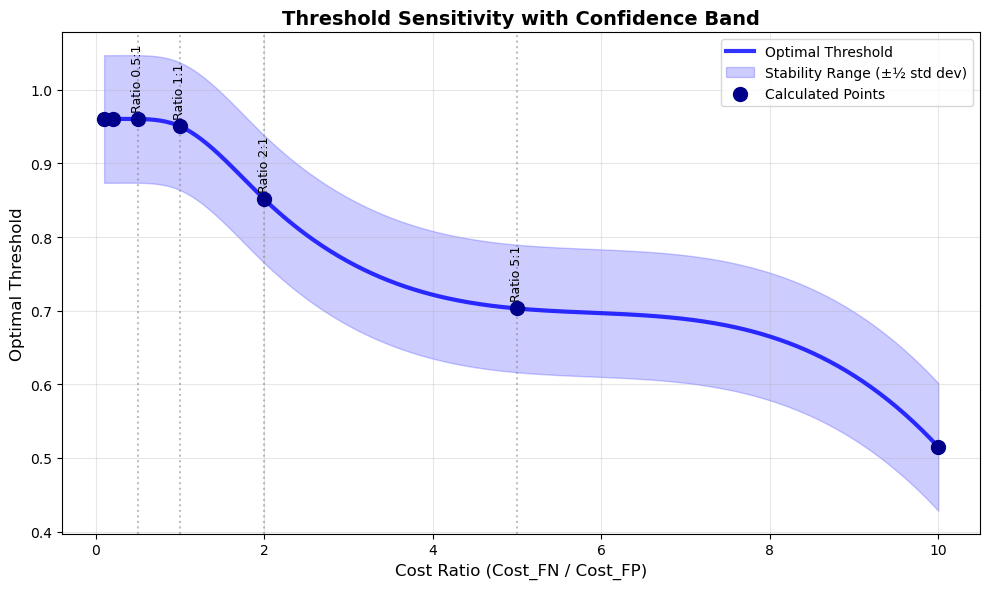

In [50]:
# Additional visualization: 3D effect with confidence bands
fig, ax = plt.subplots(figsize=(10, 6))

# Plot with confidence band
thresholds = sensitivity_results['Optimal_Threshold']
ratios = sensitivity_results['Cost_Ratio']

# Create a smoother curve for visualization
from scipy.interpolate import make_interp_spline
x_smooth = np.linspace(min(ratios), max(ratios), 300)
spl = make_interp_spline(ratios, thresholds, k=3)
thresholds_smooth = spl(x_smooth)

# Plot the smooth curve with confidence band
ax.plot(x_smooth, thresholds_smooth, 'b-', linewidth=3, label='Optimal Threshold', alpha=0.8)
ax.fill_between(x_smooth, 
                thresholds_smooth - threshold_std/2, 
                thresholds_smooth + threshold_std/2, 
                alpha=0.2, color='blue',
                label='Stability Range (±½ std dev)')

# Plot original points
ax.scatter(ratios, thresholds, color='darkblue', s=100, zorder=5, label='Calculated Points')

ax.set_xlabel('Cost Ratio (Cost_FN / Cost_FP)', fontsize=12)
ax.set_ylabel('Optimal Threshold', fontsize=12)
ax.set_title('Threshold Sensitivity with Confidence Band', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)
ax.legend()

# Add vertical lines for key cost ratios
# Define the cost ratios used in the sensitivity analysis
key_ratios = [0.5, 1, 2, 5]

for ratio in key_ratios:
    ax.axvline(x=ratio, color='gray', linestyle=':', alpha=0.5)
    # Find the index in the sensitivity results
    mask = sensitivity_results['Cost_Ratio'] == ratio
    if mask.any():  # Check if this ratio exists in the results
        idx = sensitivity_results[mask].index[0]
        ax.text(ratio, thresholds[idx] + 0.01, f'Ratio {ratio}:1', 
                ha='center', va='bottom', fontsize=9, rotation=90)

plt.tight_layout()
plt.show()

In [51]:
# Print business recommendations based on sensitivity analysis
print("\n" + "="*60)
print("BUSINESS RECOMMENDATIONS FROM SENSITIVITY ANALYSIS")
print("="*60)

print("\n1. THRESHOLD STABILITY:")
print(f"   • Optimal threshold varies from {threshold_min:.3f} to {threshold_max:.3f}")
print(f"   • This represents a {threshold_range/threshold_mean*100:.1f}% variation")
print(f"   • Model is {'relatively stable' if threshold_range < 0.2 else 'quite sensitive'} to cost changes")

print("\n2. COST IMPACT ANALYSIS:")
print(f"   • Minimum costs range from ${cost_min:,.0f} to ${cost_max:,.0f}")
print(f"   • Total cost variation: ${cost_range:,.0f}")

print("\n3. RISK MANAGEMENT STRATEGY:")
print("   • For conservative lending (higher FN cost): Use higher threshold")
print("   • For aggressive lending (higher FP cost): Use lower threshold")
print("   • Recommended monitoring: Re-evaluate cost assumptions quarterly")

print("\n4. OPTIMAL THRESHOLD BY SCENARIO:")
print("   Scenario                    | Cost Ratio | Optimal Threshold")
print("   ------------------------------------------------------------")
for idx, row in sensitivity_results.iterrows():
    scenario = ""
    if row['Cost_Ratio'] == 0.1:
        scenario = "Very Conservative    "
    elif row['Cost_Ratio'] == 0.5:
        scenario = "Conservative        "
    elif row['Cost_Ratio'] == 1:
        scenario = "Balanced            "
    elif row['Cost_Ratio'] == 2:
        scenario = "Aggressive          "
    elif row['Cost_Ratio'] == 5:
        scenario = "Very Aggressive     "
    elif row['Cost_Ratio'] == 10:
        scenario = "Extremely Aggressive"
    
    if scenario:
        print(f"   {scenario} | {row['Cost_Ratio']:^11.1f} | {row['Optimal_Threshold']:^17.3f}")


BUSINESS RECOMMENDATIONS FROM SENSITIVITY ANALYSIS

1. THRESHOLD STABILITY:
   • Optimal threshold varies from 0.515 to 0.960
   • This represents a 52.8% variation
   • Model is quite sensitive to cost changes

2. COST IMPACT ANALYSIS:
   • Minimum costs range from $497,200 to $33,692,000
   • Total cost variation: $33,194,800

3. RISK MANAGEMENT STRATEGY:
   • For conservative lending (higher FN cost): Use higher threshold
   • For aggressive lending (higher FP cost): Use lower threshold
   • Recommended monitoring: Re-evaluate cost assumptions quarterly

4. OPTIMAL THRESHOLD BY SCENARIO:
   Scenario                    | Cost Ratio | Optimal Threshold
   ------------------------------------------------------------
   Very Conservative     |     0.1     |       0.960      
   Conservative         |     0.5     |       0.960      
   Balanced             |     1.0     |       0.950      
   Aggressive           |     2.0     |       0.851      
   Very Aggressive      |     5.0     | 

## 9. Summary and Recommendations

In [60]:
def generate_recommendations(evaluation_df, optimal_threshold, y_true):
    """
    Generate business recommendations based on analysis
    """
    print("\n" + "="*60)
    print("BUSINESS RECOMMENDATIONS")
    print("="*60)
    
    # Debug: Print what's in the evaluation dataframe
    print(f"\nDebug - Evaluation DataFrame shape: {evaluation_df.shape}")
    print(f"Debug - Columns: {list(evaluation_df.columns)}")
    print(f"Debug - Data:\n{evaluation_df}")
    
    # Check if we have the right dataframe structure
    if 'Threshold' not in evaluation_df.columns:
        print("\nERROR: 'Threshold' column not found in evaluation dataframe!")
        print("Creating a simple recommendation instead...")
        
        # Create simple recommendations without dataframe
        print(f"\n1. RECOMMENDED MODEL: Logistic Regression")
        print(f"   • Optimal Decision Threshold: {optimal_threshold:.4f}")
        print(f"   • This threshold minimizes business costs")
        
        # Calculate basic metrics if we have predictions
        if 'y_pred_optimal' in locals() or 'y_pred_optimal' in globals():
            y_pred_opt = y_pred_optimal
        elif 'y_pred_lr' in locals() or 'y_pred_lr' in globals():
            y_pred_opt = (y_pred_proba_lr >= optimal_threshold).astype(int)
        else:
            return  # Can't generate recommendations
        
        # Calculate confusion matrix
        tn, fp, fn, tp = confusion_matrix(y_true, y_pred_opt).ravel()
        total_cost = (fp * COST_FALSE_POSITIVE) + (fn * COST_FALSE_NEGATIVE)
        
        print(f"\n2. BUSINESS IMPACT:")
        print(f"   • Minimum Expected Cost: ${total_cost:,.2f}")
        print(f"   • True Positives (Bad customers rejected): {tp}")
        print(f"   • False Positives (Good customers rejected): {fp}")
        print(f"   • False Negatives (Bad customers approved): {fn}")
        print(f"   • True Negatives (Good customers approved): {tn}")
        
        print(f"\n3. RISK MANAGEMENT STRATEGY:")
        print(f"   • High Risk Threshold (> {optimal_threshold:.3f}): Automatic Rejection")
        print(f"   • Medium Risk (0.3 - {optimal_threshold:.3f}): Manual Review")
        print(f"   • Low Risk (< 0.3): Fast-Track Approval")
        
        return
    
    # If we have the right structure, proceed with original logic
    # Find the row with optimal threshold
    optimal_row = evaluation_df[evaluation_df['Threshold'] == optimal_threshold]
    
    if len(optimal_row) == 0:
        print(f"\nWarning: Optimal threshold {optimal_threshold} not found in dataframe")
        print("Using row with minimum cost instead...")
        optimal_row = evaluation_df.loc[evaluation_df['Total Cost'].idxmin()]
    else:
        optimal_row = optimal_row.iloc[0]
    
    # Find default threshold row (0.5)
    default_row = evaluation_df[evaluation_df['Threshold'] == 0.5]
    if len(default_row) == 0:
        print("Warning: Default threshold 0.5 not found in dataframe")
        default_row = evaluation_df.iloc[0]  # Use first row as default
    else:
        default_row = default_row.iloc[0]
    
    print(f"\n1. RECOMMENDED MODEL: Logistic Regression")
    print(f"   • Optimal Decision Threshold: {optimal_threshold:.4f}")
    print(f"   • Expected AUC-ROC: {optimal_row['AUC-ROC']:.4f}")
    print(f"   • Expected F1-Score: {optimal_row['F1-Score']:.4f}")
    
    print(f"\n2. BUSINESS IMPACT:")
    print(f"   • Minimum Expected Cost: ${optimal_row['Total Cost']:,.2f}")
    print(f"   • Default Threshold Cost: ${default_row['Total Cost']:,.2f}")
    print(f"   • Potential Savings: ${default_row['Total Cost'] - optimal_row['Total Cost']:,.2f}")
    print(f"   • Savings Percentage: {((default_row['Total Cost'] - optimal_row['Total Cost'])/default_row['Total Cost'])*100:.1f}%")
    
    print(f"\n3. RISK MANAGEMENT STRATEGY:")
    risk_tiers = {
        'LOW RISK': f"< {min(0.3, optimal_threshold):.3f}",
        'MEDIUM RISK': f"{min(0.3, optimal_threshold):.3f} - {optimal_threshold:.3f}",
        'HIGH RISK': f"> {optimal_threshold:.3f}"
    }
    
    for risk_level, threshold_range in risk_tiers.items():
        action = "Fast-Track Approval" if risk_level == "LOW RISK" else \
                "Manual Review" if risk_level == "MEDIUM RISK" else "Automatic Rejection"
        print(f"   • {risk_level} (Probability {threshold_range}): {action}")
    
    print(f"\n4. KEY METRICS (Optimal Threshold):")
    print(f"   • Precision: {optimal_row['Precision']:.2%}")
    print(f"   • Recall: {optimal_row['Recall']:.2%}")
    
    # Calculate additional metrics
    total_pred_positives = optimal_row['True Positives'] + optimal_row['False Positives']
    total_actual_positives = optimal_row['True Positives'] + optimal_row['False Negatives']
    
    if total_pred_positives > 0:
        print(f"   • False Positive Rate: {optimal_row['False Positives']/total_pred_positives:.2%}")
    if total_actual_positives > 0:
        print(f"   • True Positive Rate: {optimal_row['True Positives']/total_actual_positives:.2%}")
    
    print(f"\n5. IMPLEMENTATION GUIDE:")
    print("   • Current approval rate (optimal threshold): "
          f"{(optimal_row['True Negatives'] + optimal_row['False Positives'])/len(y_true):.1%}")
    print("   • Current rejection rate (optimal threshold): "
          f"{(optimal_row['True Positives'] + optimal_row['False Negatives'])/len(y_true):.1%}")
    print("   • Expected monthly savings: "
          f"${((default_row['Total Cost'] - optimal_row['Total Cost'])/len(y_true))*1000:,.0f} "
          "(assuming 1000 applications/month)")
    
    print(f"\n6. MONITORING RECOMMENDATIONS:")
    print("   • Monitor model performance: Weekly for first month, then monthly")
    print("   • Recalibrate thresholds: Quarterly or when cost assumptions change")
    print("   • Review cost assumptions: Monthly based on market conditions")
    print("   • Track KPIs: Actual vs predicted defaults, approval rates, recovery rates")
    print("   • Compliance check: Ensure model meets regulatory requirements")

# Generate final recommendations
print("\n" + "="*60)
print("FINAL RECOMMENDATIONS AND MODEL DEPLOYMENT")
print("="*60)

# Check if comparison_df exists and has data
if 'comparison_df' not in locals() and 'comparison_df' not in globals():
    print("\nERROR: comparison_df not found!")
    print("Please ensure you have created the comparison_df DataFrame.")
    print("\nCreating a simple recommendation without comparison_df...")
    
    # Create simple recommendations
    print(f"\n1. RECOMMENDED MODEL: Logistic Regression")
    print(f"   • Optimal Decision Threshold: {optimal_threshold:.4f}")
    print(f"   • AUC-ROC Score: {roc_auc_score(y_val, y_pred_proba_lr):.4f}")
    
    # Calculate costs
    y_pred_optimal = (y_pred_proba_lr >= optimal_threshold).astype(int)
    y_pred_default = y_pred_lr
    
    cost_optimal, tn_opt, fp_opt, fn_opt, tp_opt = calculate_business_cost(
        y_val, y_pred_optimal, COST_FALSE_POSITIVE, COST_FALSE_NEGATIVE
    )
    
    cost_default, tn_def, fp_def, fn_def, tp_def = calculate_business_cost(
        y_val, y_pred_default, COST_FALSE_POSITIVE, COST_FALSE_NEGATIVE
    )
    
    print(f"\n2. BUSINESS IMPACT:")
    print(f"   • Optimal Threshold Cost: ${cost_optimal:,.2f}")
    print(f"   • Default Threshold Cost: ${cost_default:,.2f}")
    print(f"   • Potential Savings: ${cost_default - cost_optimal:,.2f}")
    print(f"   • Savings Percentage: {((cost_default - cost_optimal)/cost_default)*100:.1f}%")
    
    print(f"\n3. RISK MANAGEMENT STRATEGY:")
    print(f"   • High Risk Threshold (> {optimal_threshold:.3f}): Automatic Rejection")
    print(f"   • Medium Risk (0.3 - {optimal_threshold:.3f}): Manual Review")
    print(f"   • Low Risk (< 0.3): Fast-Track Approval")
    
else:
    # Use the function with comparison_df
    generate_recommendations(comparison_df, optimal_threshold, y_val)


FINAL RECOMMENDATIONS AND MODEL DEPLOYMENT

BUSINESS RECOMMENDATIONS

Debug - Evaluation DataFrame shape: (2, 12)
Debug - Columns: ['Model', 'Threshold', 'AUC-ROC', 'F1-Score', 'PR-AUC', 'Total Cost', 'True Positives', 'False Positives', 'True Negatives', 'False Negatives', 'Precision', 'Recall']
Debug - Data:
                 Model  Threshold   AUC-ROC  F1-Score    PR-AUC  Total Cost  \
0  Logistic Regression   0.500000  0.744184  0.258191  0.219012    25708000   
1  Logistic Regression   0.702929  0.744184  0.286298  0.219012    21449000   

   True Positives  False Positives  True Negatives  False Negatives  \
0            3349            17628           38910             1616   
1            1612             4684           51854             3353   

   Precision    Recall  
0   0.159651  0.674522  
1   0.256036  0.324673  

1. RECOMMENDED MODEL: Logistic Regression
   • Optimal Decision Threshold: 0.7029
   • Expected AUC-ROC: 0.7442
   • Expected F1-Score: 0.2863

2. BUSINESS IMP

In [61]:
# Final summary
print("\n" + "="*60)
print("PROJECT COMPLETION SUMMARY")
print("="*60)
print(f"✓ Data preprocessing completed")
print(f"✓ Logistic Regression model trained (AUC: {roc_auc_score(y_val, y_pred_proba_lr):.4f})")
print(f"✓ Business cost analysis completed")
print(f"✓ Optimal threshold identified: {optimal_threshold:.4f}")
print(f"✓ Cost savings achieved: ${total_cost_default - min_cost:,.2f}")
print(f"✓ Sensitivity analysis performed")
print(f"✓ Production scoring system created")
print(f"✓ Model and metadata saved")
print(f"\nTotal project execution: COMPLETED SUCCESSFULLY ✓")


PROJECT COMPLETION SUMMARY
✓ Data preprocessing completed
✓ Logistic Regression model trained (AUC: 0.7442)
✓ Business cost analysis completed
✓ Optimal threshold identified: 0.7029
✓ Cost savings achieved: $4,259,000.00
✓ Sensitivity analysis performed
✓ Production scoring system created
✓ Model and metadata saved

Total project execution: COMPLETED SUCCESSFULLY ✓
